In [611]:
import numpy as np
seed = 108

def generate_data(m, n):
    # A2 = np.random.randn(m, n)
    # while np.linalg.matrix_rank(A2) < m: # Ensuring A2 has full rank
    #     A2 = np.random.randn(m, n) 
    # np.random.seed(seed)
    U, S, Vt = np.linalg.svd(np.random.randn(m, n), full_matrices=False)
    Sigma = np.diag(np.random.rand(min(m,n)) + 1e-6)  # Add small value to avoid zero singular values
    A2 = U @ Sigma @ Vt
    # print(np.linalg.matrix_rank(A2))
    A1 = np.random.randn(m, n)

    x_hat = np.abs(np.random.randn(n)) + 1e-6  # Ensuring x_hat > 0

    b2 = A2 @ x_hat

    v1 = A1 @ x_hat

    b1 = v1 + (1 / 10) * np.linalg.norm(v1, np.inf) * np.ones(m)

    return A1, A2, b1, b2, x_hat

# # Example usage
# m = 5  # Number of constraints
# n = 10  # Number of variables

# # A1, A2, b1, b2, x_hat = generate_data(m, n,seed)

# print("A1:\n", A1)
# print("A2:\n", A2)
# print("b1:\n", b1)
# print("b2:\n", b2)
# print("x_hat:\n", x_hat)

In [604]:
def phase1_barrier_new(A1, A2, b1, b2, x0, s0, t0=1.0, mu=10.0, eps=1e-6, max_iter=100):
    def f(z, t, A1, b1):
        x = z[:n]
        s = z[n]
        # if np.min(x) < 0:
        #     return np.inf
        if np.min(b1 + s - A1 @ x) <= 0 or np.min(s+x) <= 0 :
            return np.inf
        phi = -np.sum(np.log(b1 + s - A1 @ x)) - np.sum(np.log(s+x))
        return t * s + phi

    def grad_f(z, t, A1, b1):
        x = z[:n]
        s = z[n]
        # grad_x = -A1.T @ (1 / (b1 + s - A1 @ x)) - 1 / x
        grad_x = A1.T @ (1 / (b1 + s - A1 @ x)) - 1 / (x+s)
        grad_s = t - np.sum(1 / (b1 + s - A1 @ x)) - np.sum(1/(x+s))
        return np.hstack([grad_x, grad_s])

    def hess_f(z, t, A1, b1):
        x = z[:n]
        s = z[n]
        H_xx = A1.T @ np.diag(1 / (b1 + s - A1 @ x)**2) @ A1 + np.diag(1 / (s+x)**2)
        H_xs = -A1.T @ (1 / (b1 + s - A1 @ x)**2) + (1/((s+x)**2))
        H_ss = np.sum(1 / (b1 + s - A1 @ x)**2) + np.sum(1/(s+x)**2)
        H = np.vstack([np.hstack([H_xx, H_xs.reshape(-1, 1)]), np.hstack([H_xs, H_ss])])
        # print(np.shape(H_xx))
        # print(np.shape(H_xs))
        # print(np.shape(H_ss))
        # H = np.block([[H_xx,H_xs.reshape(-1,1)],[H_xs.reshape(-1,1).T,H_ss]])
        return H

    def newton_step(z, t, A1, b1, A2, b2):
        H = hess_f(z, t, A1, b1)
        g = grad_f(z, t, A1, b1)
        A = np.column_stack([A2,np.zeros(A2.shape[0])])
        b = b2
        KKT_matrix = np.block([[H, A.T],[ A, np.zeros((A.shape[0], A.shape[0]))]])
        rhs = np.hstack([-g, np.zeros(A.shape[0])])
        # rhs = np.hstack([-g-A.T @ lam, b-A@z])
        delta_z = np.linalg.solve(KKT_matrix, rhs)
        return delta_z[:len(z)], H,g

    def minimize_f(t, A1, b1, A2, b2, z0, tol=1e-6, max_iter=100):
        z = z0
        # print(z0)
        # lam = np.zeros(A1.shape[0])
        iter_new = 0
        for i in range(max_iter):
            # print(i,f(z, t, A1, b1))
            delta_z, H,grad = newton_step(z, t, A1, b1, A2, b2)
            # print(delta_z)
            
            # lam += delta_z[len(z):]÷
            lambd = delta_z.T @ H @ delta_z
            if lambd/2 < tol or z[-1] < -1000:
                # print(i)
                break
            alpha = 0.1
            t_line = 1
            while f(z+t_line * delta_z, t, A1, b1) > f(z, t, A1, b1) + alpha * t_line * np.dot(grad,delta_z) :
                t_line = 0.8 * t_line
            z += t_line * delta_z
            iter_new += 1
            
            # print(t_line)
            # print(z)
        return z, iter_new
    
    z = np.hstack([x0,s0])
    m, n = A1.shape
    t = t0
    iteration = 0
    iteration_new = 0
    for _ in range(max_iter):
        # z, _ = equality_constrained_newton(compute_grad_hessian, A2, b2, z,A1,b1,t)
        z, iter_new = minimize_f(t, A1, b1, A2, b2, z)
        # print(z[-1])
        # z = minimize()
        if m/t < eps or z[-1] < -10000:
            break
        t = mu * t
        iteration += 1
        iteration_new += iter_new
    # print(t)
    return z, iteration, iteration_new

In [605]:
def phase2_barrier(A1, A2, b1, b2, t0=1.0, mu=10.0, eps=1e-6, max_iter=100):
    x0 = np.linalg.pinv(A2) @ b2
    s0 = np.max(A1 @ x0 - b1) + 100
    # z,iter_1 = phase1_barrier(A1, A2, b1, b2, x0, s0, t0, mu)
    z, iter_1,iter_2 = phase1_barrier_new(A1, A2, b1, b2, x0, s0, t0, mu, eps)
    if z[-1] > 0 :
        print("The problem is infeasible")
        return
    
    def f0(x):
        if np.min(x) < 0:
            return np.inf
        
        return np.sum(np.where(x > 0, x * np.log(x), 0))

    def phi(x, A1, b1):
        if np.min(b1 - A1 @ x) < 0: 
            return np.inf
        return -np.sum(np.log(b1 - A1 @ x))
    
    def f(x,A1,b1,t):
        return t*f0(x) + phi(x,A1,b1)

#     def grad_f0(x):
#         if np.min(x) <= 0 :
#             return np.inf
#         return np.log(x) + 1

#     def grad_phi(x, A1, b1):
#         return A1.T @ (1 / (b1 - A1 @ x)) - 1 / x

#     def hess_f0(x):
#         return np.diag(1 / x)

#     def hess_phi(x, A1, b1):
#         diag1 = 1 / (b1 - A1 @ x)**2
#         diag2 = 1 / x**2
#         return -A1.T @ np.diag(diag1) @ A1 + np.diag(diag2)
    def grad_f0(x):
        if np.min(x) <= 0 :
            return np.inf
        return np.log(x) + 1

    def grad_phi(x, A1, b1):
        return A1.T @ (1 / (b1 - A1 @ x))

    def hess_f0(x):
        return np.diag(1 / x)

    def hess_phi(x, A1, b1):
        diag1 = 1 / (b1 - A1 @ x)**2
        # diag2 = 1 / x**2
        return A1.T @ np.diag(diag1) @ A1
    

    def newton_method(A1, b1, A2, b2, x0, t, tol=1e-6, max_iter=100):
        x = x0
        iter_new = 0
        for i in range(max_iter):
            grad = t * grad_f0(x) + grad_phi(x, A1, b1)
            # print(grad)
            hess = t * hess_f0(x) + hess_phi(x, A1, b1)

            # Newton step with equality constraint
            KKT_matrix = np.block([[hess, A2.T], [A2, np.zeros((A2.shape[0], A2.shape[0]))]])
            rhs = np.concatenate([-grad, np.zeros(A2.shape[0])])
            delta = np.linalg.solve(KKT_matrix, rhs)
            delta_x = delta[:len(x)]

            
            lambd = delta_x.T @ hess @ delta_x
            if lambd/2 < tol or lambd == np.nan:
                break
            alpha = 0.1
            t_line = 1
            # print(t_line * delta_x)
            while f(x+t_line * delta_x, A1, b1,t) > f(x, A1, b1,t) + alpha * t_line * np.dot(grad,delta_x) :
                t_line = 0.8 * t_line
            x = x + t_line * delta_x
            iter_new += 1
            # print(x)
    
        return x, iter_new
    t = t0
    m = A1.shape[0]
    iteration = 0
    iteration_new = 0
    for _ in range(max_iter):
        x,iter_new = newton_method(A1, b1, A2, b2, z[:-1], t)
        if m/t < eps:
            break
        t = t * mu
        iteration += 1
        iteration_new += iter_new
    return x, iter_1+iteration,iter_2+iteration_new
    
    

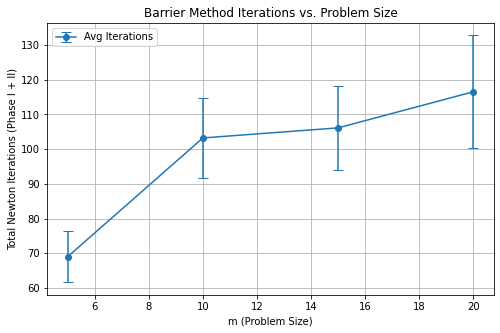

In [608]:
import matplotlib.pyplot as plt

m_list = [5,10,15,20]
mean_iterations = []
std_iterations = []
for m in m_list :
    n = 2*m
    tot_inter = []
    for _ in range(10):
        A1, A2, b1, b2, x_hat = generate_data(m, n)
        # print("A1:\n", A1)
        # print("A2:\n", A2)
        # print("b1:\n", b1)
        # print("b2:\n", b2)
        # print("x_hat:\n", x_hat)
        x, itern,iternew = phase2_barrier(A1,A2,b1,b2,eps=1e-4)
        # print(x)
        # print(np.linalg.norm(x_hat-x))
        tot_inter.append(iternew)
    mean_iterations.append(np.mean(tot_inter))
    std_iterations.append(np.std(tot_inter))
    
    
plt.figure(figsize=(8, 5))
plt.errorbar(m_list, mean_iterations, yerr=std_iterations, fmt='-o', capsize=5, label="Avg Iterations")
plt.xlabel("m (Problem Size)")
plt.ylabel("Total Newton Iterations (Phase I + II)")
plt.title("Barrier Method Iterations vs. Problem Size")
plt.legend()
plt.grid(True)
plt.show()


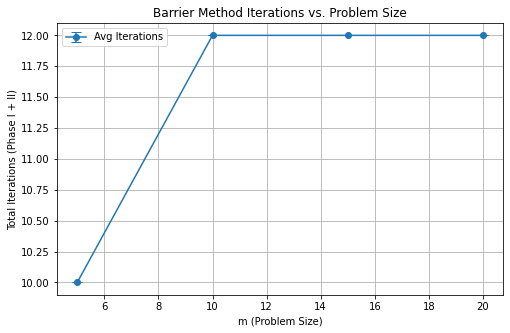

In [610]:
import matplotlib.pyplot as plt

m_list = [5,10,15,20]
mean_iterations = []
std_iterations = []
for m in m_list :
    n = 2*m
    tot_inter = []
    for _ in range(10):
        A1, A2, b1, b2, x_hat = generate_data(m, n)
        # print("A1:\n", A1)
        # print("A2:\n", A2)
        # print("b1:\n", b1)
        # print("b2:\n", b2)
        # print("x_hat:\n", x_hat)
        x, itern,iternew = phase2_barrier(A1,A2,b1,b2,eps=1e-4)
        # print(x)
        # print(np.linalg.norm(x_hat-x))
        tot_inter.append(itern)
    mean_iterations.append(np.mean(tot_inter))
    std_iterations.append(np.std(tot_inter))
    
    
plt.figure(figsize=(8, 5))
plt.errorbar(m_list, mean_iterations, yerr=std_iterations, fmt='-o', capsize=5, label="Avg Iterations")
plt.xlabel("m (Problem Size)")
plt.ylabel("Total Iterations (Phase I + II)")
plt.title("Barrier Method Iterations vs. Problem Size")
plt.legend()
plt.grid(True)
plt.show()
